# Lab 2: CIFAR-10 图像分类任务 - 网络设计和自动调参

## 任务

本次实验的任务是自己设计一个 CNN 模型，对 CIFAR-10 进行图像分类。在设计模型的过程中，你需要合理地选择网络的深度、每一层的卷积核个数、激活函数、池化操作、正则化方法等。

在设计好模型之后，手动调参找到合适的超参数是非常麻烦的，因此需要自动调参工具。

## 评估

要求：
- 为了节约时间，我们限制训练的 epoch 数不超过 20
- 过大的模型是没有意义的，因此我们限制模型的参数数量不超过 15M，你可以使用`utils.py`中的`count_parameters`函数来统计模型的参数量
- 你必须使用超参数优化工具来自动调参，并且展示调参的过程和结果。推荐使用 [optuna](https://optuna.org/)，但你也可以使用其他的工具，或者手动实现的`HyperparameterTuner`


评分标准:
- 测试集上准确率（取历史最高值）达到 80% 以上，即可获得 40 分，达到 90% 以上，即可获得满分 50 分
- 如果准确率在 80% ~ 90% 之间，剩下的10分会根据排名给分
- 如果准确率低于 80%，会根据代码完成度和准确率视情况给分

注意事项：
- 你可以自由修改数据载入函数`load_data`，例如使用额外的数据增强方法
- 你可以自由修改训练主函数`train_cifar`，例如使用不同的优化器、学习率调度器等
- 一般来说，你不需要修改`train_epoch`函数
- 你不能使用预训练权重，每次训练应该是从头开始的


## 准备代码



In [1]:
##################################################
# 请勿修改此单元格中的代码
##################################################

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader


def count_parameters(model):
    total = sum([param.nelement() for param in model.parameters()])
    print("Number of parameter: %.2fM" % (total / 1e6))
    return total


class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def train_epoch(net, train_iter, loss_fn, optimizer):
    net.train()
    device = next(net.parameters()).device
    metrics = Accumulator(4)
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        loss = loss_fn(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        metrics.add(loss * len(y), accuracy(y_hat, y) * len(y), len(y))
        train_loss = metrics[0] / metrics[2]
        train_acc = metrics[1] / metrics[2]
    return train_loss, train_acc


@torch.no_grad()
def eval_model(net, test_iter, loss_fn):
    net.eval()
    device = next(net.parameters()).device
    metrics = Accumulator(3)
    for X, y in test_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        loss = loss_fn(y_hat, y)
        metrics.add(loss * len(y), accuracy(y_hat, y) * len(y), len(y))
    test_loss = metrics[0] / metrics[2]
    test_acc = metrics[1] / metrics[2]
    return test_loss, test_acc


def accuracy(y_hat, y_true):
    y_pred = y_hat.argmax(dim=1)
    return (y_pred == y_true).float().mean().item()


logging_columns_list = ["epoch", "train_loss", "test_loss", "train_acc", "test_acc"]


def print_columns(columns_list=logging_columns_list, is_head=False, is_final_entry=False):
    print_string = ""
    for col in columns_list:
        print_string += "|  %s  " % col
    print_string += "|"
    if is_head:
        print("-" * len(print_string))
    print(print_string)
    if is_head or is_final_entry:
        print("-" * len(print_string))


def print_training_details(variables, is_final_entry):
    formatted = []
    for col in logging_columns_list:
        var = variables.get(col.strip(), None)
        if type(var) in (int, str):
            res = str(var)
        elif type(var) is float:
            res = "{:0.4f}".format(var)
        else:
            assert var is None
            res = ""
        formatted.append(res.rjust(len(col)))
    print_columns(formatted, is_final_entry=is_final_entry)

## CNN 网络设计

网络的设计其实没有标准答案，但是有一些经验可以参考。你可以参考一些经典的网络结构，比如 VGG、ResNet、DenseNet 等，也可以参考一些最近的论文，比如 MobileNet、RegNet 等。

一个聪明的办法是查看 Torchvision 中的模型文档 [Models and pre-trained weights — Torchvision 0.17 documentation](https://pytorch.org/vision/stable/models.html#classification)，里面列出的模型都是经过充分验证的，可以作为参考，并且在Table of all available classification weights 中列出了模型的参数量，可以帮助你过滤掉参数量过大的模型。

如果你觉得上面的模型都太复杂了，而你自己设计的模型无法达到要求，可以参考下面的一个结构，虽然看起来比较朴素，但在合适的数据增强和调参下，也能达到 85% 的准确率。

| Layer | Type        | Input Shape      | Output Shape     |
| ----- | ----------- | ---------------- | ---------------- |
| 1     | Conv2D      | (n, 3, 32, 32)   | (n, 32, 32, 32)  |
| 2     | ReLU        | (n, 32, 32, 32)  | (n, 32, 32, 32)  |
| 3     | Conv2D      | (n, 32, 32, 32)  | (n, 64, 32, 32)  |
| 4     | ReLU        | (n, 64, 32, 32)  | (n, 64, 32, 32)  |
| 5     | MaxPool2D   | (n, 64, 32, 32)  | (n, 64, 16, 16)  |
| 6     | Conv2D      | (n, 64, 16, 16)  | (n, 128, 16, 16) |
| 7     | ReLU        | (n, 128, 16, 16) | (n, 128, 16, 16) |
| 8     | Conv2D      | (n, 128, 16, 16) | (n, 128, 16, 16) |
| 9     | ReLU        | (n, 128, 16, 16) | (n, 128, 16, 16) |
| 10    | MaxPool2D   | (n, 128, 16, 16) | (n, 128, 8, 8)   |
| 11    | Conv2D      | (n, 128, 8, 8)   | (n, 256, 8, 8)   |
| 12    | ReLU        | (n, 256, 8, 8)   | (n, 256, 8, 8)   |
| 13    | Conv2D      | (n, 256, 8, 8)   | (n, 256, 8, 8)   |
| 14    | ReLU        | (n, 256, 8, 8)   | (n, 256, 8, 8)   |
| 15    | MaxPool2D   | (n, 256, 8, 8)   | (n, 256, 4, 4)   |
| 16    | Flatten     | (n, 256, 4, 4)   | (n, 4096)        |
| 17    | Linear      | (n, 4096)        | (n, 1024)        |
| 18    | ReLU        | (n, 1024)        | (n, 1024)        |
| 19    | Linear      | (n, 1024)        | (n, 512)         |
| 20    | ReLU        | (n, 512)         | (n, 512)         |
| 21    | Linear      | (n, 512)         | (n, 10)          |


## 超参数调节

超参数的搜索通常有以下方法：
- 网格搜索：速度很慢，效果也不好
- 随机搜索：虽然是瞎猜，但是能快速找到一个比较好的区域，优于网格搜索
- 贝叶斯优化：根据之前已经搜索过的参数的表现，来推测下一步怎么走会比较好，从而减少搜索空间，大大提升搜索效率

这里我们仿照 Optuna 的 API，实现了一个简单的`HyperparameterTuner`类，设定好目标函数后，Tuner 会通过随机的方式生成超参数，然后不断地尝试实验并记录结果，直到最大次数。

In [2]:
import random
import math
from datetime import datetime
import pandas as pd


class Trial:
    """进行一次实验的尝试"""

    def __init__(self, params):
        self.params = params

    def suggest_uniform(self, name, low, high, log_scale=False):
        if log_scale:
            value_log = random.uniform(math.log10(low), math.log10(high))
            value = 10**value_log
        else:
            value = random.uniform(low, high)
        self.params[name] = value
        return value

    def suggest_categorical(self, name, choices):
        value = random.choice(choices)
        self.params[name] = value
        return value


class HyperparameterTuner:
    def __init__(self, direction="maximize"):
        self.direction = direction
        self.best_trial = None
        self.trials = []

    def optimize(self, objective_function, n_trials):
        for i in range(n_trials):
            trial = Trial({})
            value = objective_function(trial)
            trial.value = value
            self.trials.append(trial)

            if (
                self.best_trial is None
                or (self.direction == "maximize" and value > self.best_trial.value)
                or (self.direction == "minimize" and value < self.best_trial.value)
            ):
                self.best_trial = trial

            current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            print(
                f"[{current_time}] Trial {i} finished with value: {value:.4f} and parameters: {trial.params}. Best is trial {self.trials.index(self.best_trial)} with value: {self.best_trial.value:.4f}."
            )

    def trials_dataframe(self):
        data = []
        for trial in self.trials:
            data.append({"value": trial.value, **trial.params})
        return pd.DataFrame(data)


# 需要优化的目标函数
def objective(trial: Trial):
    x = trial.suggest_uniform("x", 1e-3, 1, log_scale=True)
    y = trial.suggest_categorical("y", ["a", "b", "c"])
    y_value = {"a": 1, "b": 2, "c": 3}[y]
    z = trial.suggest_uniform("z", 1, 2)
    return x + y_value + z


tuner = HyperparameterTuner(direction="maximize")  # 最大化目标函数
tuner.optimize(objective, n_trials=10)  # 进行10次试验

[2024-04-23 16:03:58] Trial 0 finished with value: 2.4744 and parameters: {'x': 0.2523364935721321, 'y': 'a', 'z': 1.2220197761426026}. Best is trial 0 with value: 2.4744.
[2024-04-23 16:03:58] Trial 1 finished with value: 2.1928 and parameters: {'x': 0.003830162719045205, 'y': 'a', 'z': 1.1889879449887533}. Best is trial 0 with value: 2.4744.
[2024-04-23 16:03:58] Trial 2 finished with value: 2.1404 and parameters: {'x': 0.01632866679741237, 'y': 'a', 'z': 1.1240900117434254}. Best is trial 0 with value: 2.4744.
[2024-04-23 16:03:58] Trial 3 finished with value: 2.8551 and parameters: {'x': 0.0048874304184094945, 'y': 'a', 'z': 1.8501790601323647}. Best is trial 3 with value: 2.8551.
[2024-04-23 16:03:58] Trial 4 finished with value: 4.2525 and parameters: {'x': 0.017532642369331684, 'y': 'c', 'z': 1.2349643080431485}. Best is trial 4 with value: 4.2525.
[2024-04-23 16:03:58] Trial 5 finished with value: 3.8145 and parameters: {'x': 0.01037274867613939, 'y': 'b', 'z': 1.80408625881295

接下来，我们将所有的实验记录保存到 csv 中，然后输出最优的超参数。

In [3]:
results_df = tuner.trials_dataframe()
results_df.to_csv("tuning_results_test.csv", index=False)
print(results_df)

print("\nBest parameters:", tuner.best_trial.params)
print("Best value:", tuner.best_trial.value)

      value         x  y         z
0  2.474356  0.252336  a  1.222020
1  2.192818  0.003830  a  1.188988
2  2.140419  0.016329  a  1.124090
3  2.855066  0.004887  a  1.850179
4  4.252497  0.017533  c  1.234964
5  3.814459  0.010373  b  1.804086
6  3.089769  0.029282  b  1.060487
7  2.807443  0.001921  a  1.805522
8  3.892938  0.118408  b  1.774530
9  2.130497  0.002295  a  1.128201

Best parameters: {'x': 0.017532642369331684, 'y': 'c', 'z': 1.2349643080431485}
Best value: 4.25249695041248


## 完整训练流程

下面你需要完成整个训练流程，首先是定义你的网络模型：

In [4]:
##################################################
# 在此填入你设计的网络模型, 并展示模型参数量
##################################################


class CifarNet(nn.Module):
    def __init__(self):
        super(CifarNet, self).__init__()
        # TODO

    def forward(self, x):
        # TODO
        return x


model_test = CifarNet()
count_parameters(model_test)

x_test = torch.randn(20, 3, 32, 32)
y_test = model_test(x_test)
assert y_test.shape == torch.Size([20, 10]), f"Expected output shape: [20, 10], but got {y_test.shape}"

Number of parameter: 5.85M


然后是载入数据集，你可以在这里设置你自己的数据增强方法

In [5]:
import torch
import torchvision.transforms as T


def load_data(root="cifar10", batch_size=64):
    MEAN = (0.4914, 0.4822, 0.4465)
    STD = (0.2023, 0.1994, 0.2010)
    train_trans = T.Compose(
        [
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize(MEAN, STD),
        ]
    )
    test_trans = T.Compose([T.ToTensor(), T.Normalize(MEAN, STD)])

    train_data = torchvision.datasets.CIFAR10(root=root, train=True, download=False, transform=train_trans)
    test_data = torchvision.datasets.CIFAR10(root=root, train=False, download=False, transform=test_trans)

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    return train_loader, test_loader

下面是一个用 HyperparameterTuner 自动调参的大致框架，你可以替换成第三方的自动调参库，效果会好很多。
从使用难度方面来推荐，[Optuna](https://optuna.org/) >> [Ax](https://ax.dev/) > [Ray Tune](https://docs.ray.io/en/master/tune/index.html).

In [6]:
from tqdm import tqdm


def train_cifar(config):
    # TODO

    best_acc = 0
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer)
        test_loss, test_acc = eval_model(model, test_loader, loss_fn)
        if test_acc > best_acc:
            best_acc = test_acc
    return best_acc


def objective(trial):
    # TODO

    return test_acc


tuner = HyperparameterTuner(direction="maximize")
tuner.optimize(objective, n_trials=10)
tuner.trials_dataframe().to_csv("tuning_results.csv", index=False)

100%|██████████| 20/20 [01:53<00:00,  5.66s/it]


[2024-04-23 16:05:52] Trial 0 finished with value: 0.8535 and parameters: {'lr': 0.0009017796740736869}. Best is trial 0 with value: 0.8535.


100%|██████████| 20/20 [01:52<00:00,  5.65s/it]


[2024-04-23 16:07:46] Trial 1 finished with value: 0.8401 and parameters: {'lr': 0.0006033828469614485}. Best is trial 0 with value: 0.8535.


100%|██████████| 20/20 [01:53<00:00,  5.66s/it]


[2024-04-23 16:09:40] Trial 2 finished with value: 0.8513 and parameters: {'lr': 0.0012317978160083776}. Best is trial 0 with value: 0.8535.


100%|██████████| 20/20 [01:53<00:00,  5.66s/it]


[2024-04-23 16:11:34] Trial 3 finished with value: 0.8304 and parameters: {'lr': 0.0004789542201019964}. Best is trial 0 with value: 0.8535.


100%|██████████| 20/20 [01:53<00:00,  5.66s/it]


[2024-04-23 16:13:27] Trial 4 finished with value: 0.8428 and parameters: {'lr': 0.0005507435792967121}. Best is trial 0 with value: 0.8535.


100%|██████████| 20/20 [01:53<00:00,  5.66s/it]


[2024-04-23 16:15:21] Trial 5 finished with value: 0.6968 and parameters: {'lr': 0.00014395519474867622}. Best is trial 0 with value: 0.8535.


100%|██████████| 20/20 [01:53<00:00,  5.66s/it]


[2024-04-23 16:17:15] Trial 6 finished with value: 0.6951 and parameters: {'lr': 0.00014349317193019327}. Best is trial 0 with value: 0.8535.


100%|██████████| 20/20 [01:53<00:00,  5.65s/it]


[2024-04-23 16:19:09] Trial 7 finished with value: 0.7463 and parameters: {'lr': 0.00020962456711357653}. Best is trial 0 with value: 0.8535.


100%|██████████| 20/20 [01:53<00:00,  5.66s/it]


[2024-04-23 16:21:02] Trial 8 finished with value: 0.8470 and parameters: {'lr': 0.0012811732358905537}. Best is trial 0 with value: 0.8535.


100%|██████████| 20/20 [01:53<00:00,  5.66s/it]

[2024-04-23 16:22:56] Trial 9 finished with value: 0.6513 and parameters: {'lr': 0.00011190569222713818}. Best is trial 0 with value: 0.8535.


请读取保存的 csv 文件，然后按顺序打印出Top5的超参数

In [7]:
import pandas as pd

results_df = pd.read_csv("tuning_results.csv")
results_df = results_df.sort_values(by="value", ascending=False)
results_df.head(5)

,value,lr
0,0.8535,0.000902
2,0.8513,0.001232
8,0.8470,0.001281
4,0.8428,0.000551
1,0.8401,0.000603


使用最优的超参数，重新训练模型，最后展示训练过程中的 loss 和 accuracy 曲线

In [8]:
opt_cfg = results_df.iloc[0].to_dict()
epochs = 20
batch_size = 512
lr = opt_cfg["lr"]
train_loader, test_loader = load_data("cifar10", batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CifarNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

train_ls, test_ls, train_acc_ls, test_acc_ls = [], [], [], []
print_columns(is_head=True)
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer)
    test_loss, test_acc = eval_model(model, test_loader, loss_fn)
    print_training_details(locals(), is_final_entry=True if epoch == epochs else False)
    train_ls.append(train_loss)
    test_ls.append(test_loss)
    train_acc_ls.append(train_acc)
    test_acc_ls.append(test_acc)

-------------------------------------------------------------------
|  epoch  |  train_loss  |  test_loss  |  train_acc  |  test_acc  |
-------------------------------------------------------------------
|      1  |      1.9695  |     1.6836  |     0.2552  |    0.3693  |
|      2  |      1.4995  |     1.2882  |     0.4431  |    0.5262  |
|      3  |      1.2408  |     1.2078  |     0.5460  |    0.5739  |
|      4  |      1.0706  |     0.9475  |     0.6098  |    0.6606  |
|      5  |      0.9402  |     0.8487  |     0.6623  |    0.6974  |
|      6  |      0.8258  |     0.7977  |     0.7042  |    0.7203  |
|      7  |      0.7451  |     0.7283  |     0.7354  |    0.7461  |
|      8  |      0.6870  |     0.6980  |     0.7565  |    0.7534  |
|      9  |      0.6416  |     0.6738  |     0.7727  |    0.7677  |


|     10  |      0.5894  |     0.5999  |     0.7941  |    0.7926  |
|     11  |      0.5548  |     0.5888  |     0.8058  |    0.8023  |
|     12  |      0.5077  |     0.5615  |     0.8217  |    0.8047  |
|     13  |      0.4849  |     0.5670  |     0.8313  |    0.8076  |
|     14  |      0.4625  |     0.5246  |     0.8374  |    0.8248  |
|     15  |      0.4482  |     0.5216  |     0.8425  |    0.8221  |
|     16  |      0.4183  |     0.5150  |     0.8536  |    0.8231  |
|     17  |      0.3924  |     0.4862  |     0.8639  |    0.8364  |
|     18  |      0.3830  |     0.4831  |     0.8651  |    0.8354  |
|     19  |      0.3556  |     0.4969  |     0.8749  |    0.8387  |
|     20  |      0.3407  |     0.4732  |     0.8797  |    0.8451  |
-------------------------------------------------------------------


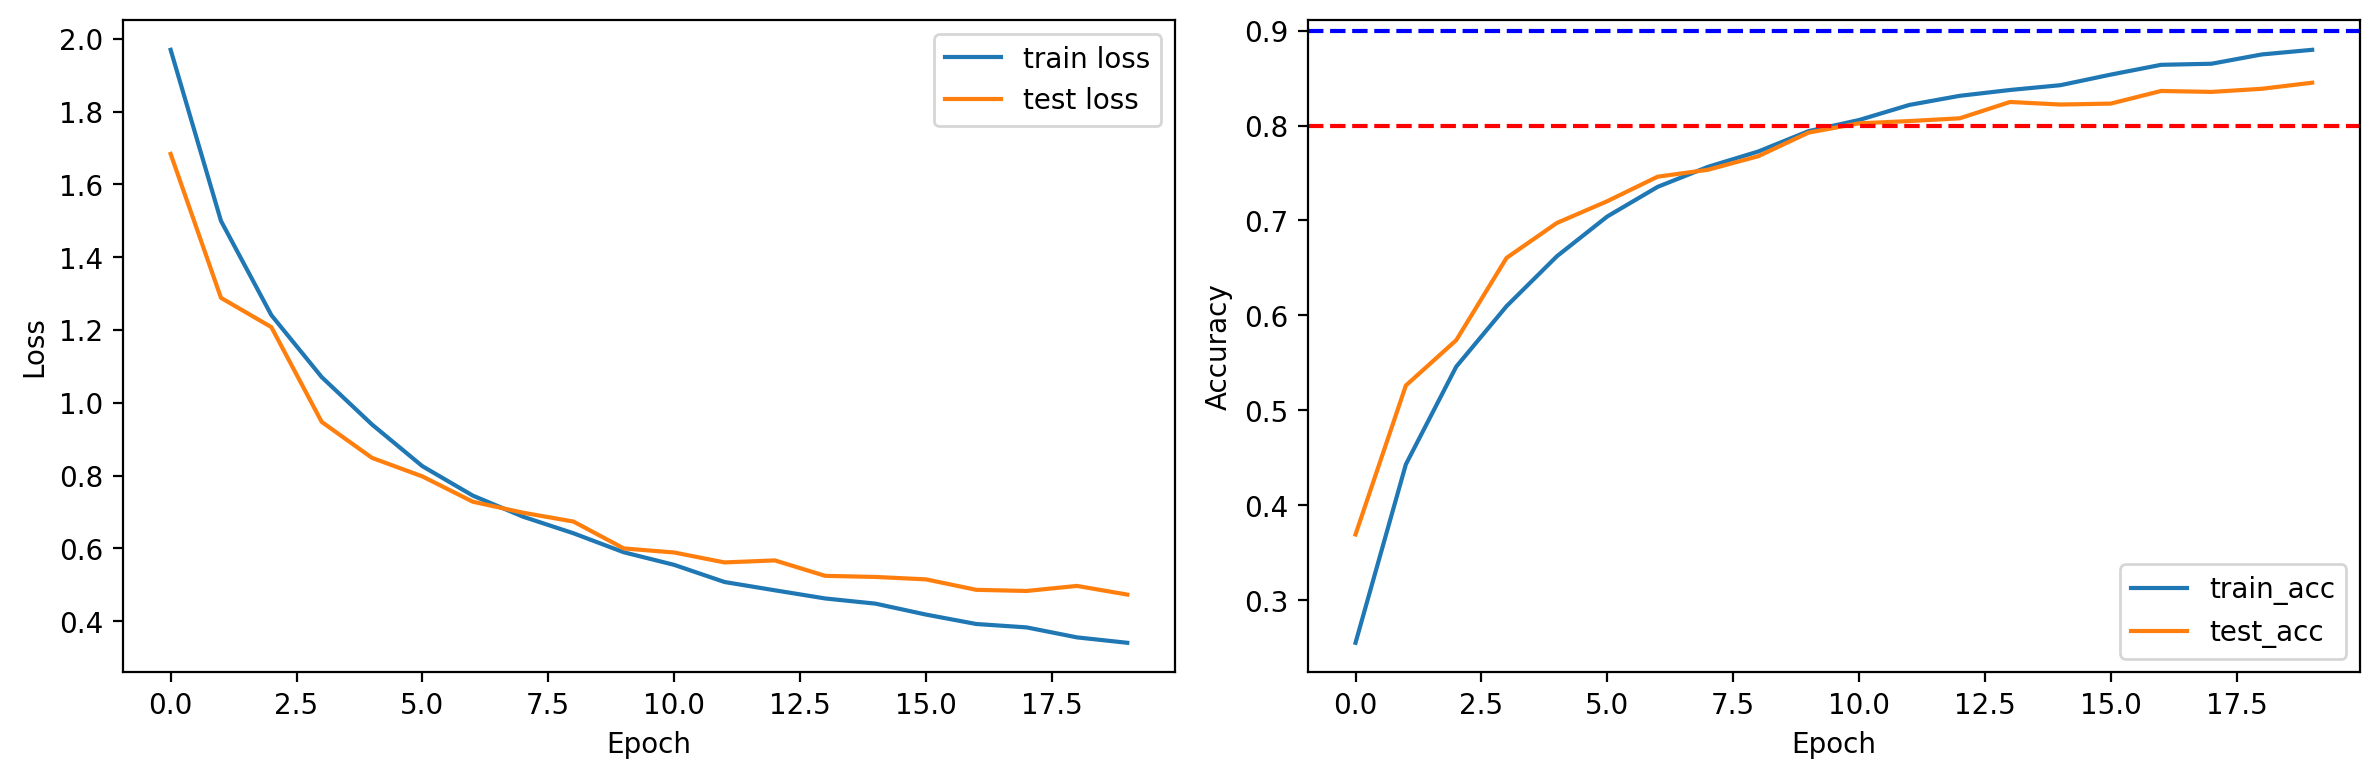

Best test accuaracy:  0.8451


In [9]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# 绘制第一个子图
axs[0].plot(train_ls, label="train loss")
axs[0].plot(test_ls, label="test loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

# 绘制第二个子图
axs[1].plot(train_acc_ls, label="train_acc")
axs[1].plot(test_acc_ls, label="test_acc")
axs[1].axhline(y=0.8, color='r', linestyle='--')  # 添加 y=0.8 的参考线
axs[1].axhline(y=0.9, color='b', linestyle='--')  # 添加 y=0.9 的参考线
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()
print("Best test accuaracy: ", max(test_acc_ls))